In [2]:
import nibabel as nib
from pathlib import Path
from monai.transforms import LoadImage
import SimpleITK as sitk
PATH = Path("/home/vzalevskyi/projects/fetalsyngen/data/derivatives/")

for imgp in PATH.glob('**/*.nii.gz'):
    img = nib.load(str(imgp))
    img_header = img.header
    img_header.set_data_dtype('int8')
    img_int8 = nib.Nifti1Image(img.get_fdata().astype('int8'), img.affine, img.header)
    nib.save(img_int8, str(imgp))

In [104]:
import numpy as np
from SimpleITK import ReadImage, GetArrayFromImage
from monai.data import MetaTensor
from torch import from_numpy

class SimpleITKReader:
    @staticmethod
    def make_affine_from_sitk(sitk_img):
        """Get affine transform in LPS"""
        if sitk_img.GetDepth() <= 0:
            return np.eye(4)

        rot = [sitk_img.TransformContinuousIndexToPhysicalPoint(p)
            for p in ((1, 0, 0),
                        (0, 1, 0),
                        (0, 0, 1),
                        (0, 0, 0))]
        rot = np.array(rot)
        affine = np.concatenate([
            np.concatenate([rot[0:3] - rot[3:], rot[3:]], axis=0),
            [[0.], [0.], [0.], [1.]]
        ], axis=1)
        affine = np.transpose(affine)
        # convert to RAS to match nibabel
        affine = np.matmul(np.diag([-1., -1., 1., 1.]), affine)
        return affine

    def __call__(self, img_path, as_meta=True):
        if isinstance(img_path, Path):
            img_path = str(img_path)
        img = ReadImage(img_path)
        affine = torch.Tensor(self.make_affine_from_sitk(img))
        img_data = GetArrayFromImage(img)
        # convert to RAS to match nibabel loading order
        img_data = from_numpy(img_data).permute(2, 1, 0)
        if as_meta:
            return MetaTensor(x=img_data, affine=affine)
        else:
            return img_data

In [63]:
import nibabel as nib
from pathlib import Path
import SimpleITK as sitk
imgs = [
    "data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_1.nii.gz",
    "data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_2.nii.gz",
    "data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_3.nii.gz",
    "data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_4.nii.gz",
]

imgs

['data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_1.nii.gz',
 'data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_2.nii.gz',
 'data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_3.nii.gz',
 'data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_4.nii.gz']

In [64]:
loader = LoadImage(reader='NibabelReader')
import torch
import matplotlib.pyplot as plt

In [70]:
nibabel_img = nib.load(imgs[0]).get_fdata()
sitk_img = sitk.GetArrayFromImage(sitk.ReadImage(str(imgs[0])))
monai_img = torch.Tensor(loader(imgs[0]))
# cast to float 64
monai_img = monai_img.double()

# turn all to tensors
nibabel_img = torch.tensor(nibabel_img)
sitk_img = torch.tensor(sitk_img).double()

# change xyz to zyx for sitk_img
sitk_img = sitk_img.permute(2, 1, 0)

In [71]:
# compare the data
print(f'Shape: nibabel-{nibabel_img.shape}, sitk-{sitk_img.shape}, monai-{monai_img.shape}')
print(f'Type : nibabel-{nibabel_img.dtype}, sitk-{sitk_img.dtype}, monai-{monai_img.dtype}')


Shape: nibabel-torch.Size([256, 256, 256]), sitk-torch.Size([256, 256, 256]), monai-torch.Size([256, 256, 256])
Type : nibabel-torch.float64, sitk-torch.float64, monai-torch.float64


In [72]:
torch.allclose(nibabel_img, sitk_img, atol=1e-6)

True

In [73]:
torch.allclose(nibabel_img, monai_img, atol=1e-6)

True

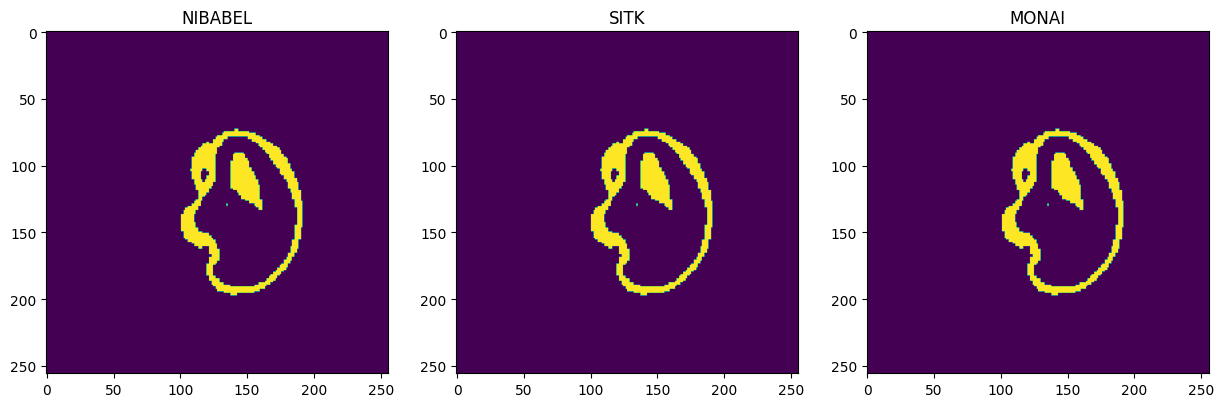

In [74]:
# plot a slice from all images
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(nibabel_img[100, :, :])
plt.title('NIBABEL')
plt.subplot(132)
plt.imshow(sitk_img[100, :, :])
plt.title('SITK')
plt.subplot(133)
plt.imshow(monai_img[100, :, :])
plt.title('MONAI')
plt.show()

In [105]:
# int8-bit images

imgs = [
    "data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_1.nii.gz",
    "data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_2.nii.gz",
    "data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_3.nii.gz",
    "data/derivatives/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_4.nii.gz",
]

sitk_loader = lambda x: torch.from_numpy(
    sitk.GetArrayFromImage(sitk.ReadImage(str(x)))
).permute(2, 1, 0)

monai_loader = SimpleITKReader()

nibabel_reader = lambda x: torch.from_numpy(nib.load(x).get_fdata())

# compare the reading speed of all loaders on imgs [read all images 10 times]

import time

nibabel_time = 0
sitk_time = 0
monai_time = 0

for i in range(10):
    start = time.time()
    for img in imgs:
        nibabel_reader(img)
    end = time.time()
    nibabel_time += end - start

    start = time.time()
    for img in imgs:
        sitk_loader(img)
    end = time.time()
    sitk_time += end - start

    start = time.time()
    for img in imgs:
        monai_loader(img)
    end = time.time()
    monai_time += end - start

# print time per image
print(f'NIBABEL: {nibabel_time / 10 / len(imgs)}')
print(f'SITK: {sitk_time / 10 / len(imgs)}')
print(f'MONAI: {monai_time / 10 / len(imgs)}')

NIBABEL: 0.028946542739868165
SITK: 0.006095361709594726
MONAI: 0.0060773491859436035


In [106]:
# float32-bit images

imgs = [
    "data/derivatives (copy)/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_1.nii.gz",
    "data/derivatives (copy)/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_2.nii.gz",
    "data/derivatives (copy)/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_3.nii.gz",
    "data/derivatives (copy)/seeds/subclasses_1/sub-sta21/anat/sub-sta21_rec-irtk_T2w_dseg_mlabel_4.nii.gz",
]
sitk_loader = lambda x: torch.from_numpy(
    sitk.GetArrayFromImage(sitk.ReadImage(str(x)))
).permute(2, 1, 0)

monai_loader = SimpleITKReader()

nibabel_reader = lambda x: torch.from_numpy(nib.load(x).get_fdata())

# compare the reading speed of all loaders on imgs [read all images 10 times]

import time

nibabel_time = 0
sitk_time = 0
monai_time = 0

for i in range(10):
    start = time.time()
    for img in imgs:
        nibabel_reader(img)
    end = time.time()
    nibabel_time += end - start

    start = time.time()
    for img in imgs:
        sitk_loader(img)
    end = time.time()
    sitk_time += end - start

    start = time.time()
    for img in imgs:
        monai_loader(img)
    end = time.time()
    monai_time += end - start

# print time per image
print(f"NIBABEL: {nibabel_time / 10 / len(imgs)}")
print(f"SITK: {sitk_time / 10 / len(imgs)}")
print(f"MONAI: {monai_time / 10 / len(imgs)}")

NIBABEL: 0.09176988005638123
SITK: 0.0810126781463623
MONAI: 0.07983453273773193


In [107]:
img1_monai = monai_loader(imgs[0])
# print affine
print(img1_monai.affine)
# print header
print(img1_monai.meta)

tensor([[  0.5000,   0.0000,   0.0000, -63.4001],
        [  0.0000,   0.5000,   0.0000, -63.8001],
        [  0.0000,   0.0000,   0.5000, -63.5999],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64)
{affine: tensor([[  0.5000,   0.0000,   0.0000, -63.4001],
        [  0.0000,   0.5000,   0.0000, -63.8001],
        [  0.0000,   0.0000,   0.5000, -63.5999],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64), space: RAS}


In [79]:
img1_monai = monai_loader(imgs[0])
# print affine
print(img1_monai.affine)
# print header
print(img1_monai.meta)

tensor([[  0.5000,   0.0000,   0.0000, -63.4001],
        [  0.0000,   0.5000,   0.0000, -63.8001],
        [  0.0000,   0.0000,   0.5000, -63.5999],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64)
{'sizeof_hdr': array(348, dtype=int32), 'extents': array(0, dtype=int32), 'session_error': array(0, dtype=int16), 'dim_info': array(0, dtype=uint8), 'dim': array([  3, 256, 256, 256,   1,   1,   1,   1], dtype=int16), 'intent_p1': array(0., dtype=float32), 'intent_p2': array(0., dtype=float32), 'intent_p3': array(0., dtype=float32), 'intent_code': array(0, dtype=int16), 'datatype': array(16, dtype=int16), 'bitpix': array(32, dtype=int16), 'slice_start': array(0, dtype=int16), 'pixdim': array([1. , 0.5, 0.5, 0.5, 1. , 1. , 1. , 1. ], dtype=float32), 'vox_offset': array(0., dtype=float32), 'scl_slope': array(nan, dtype=float32), 'scl_inter': array(nan, dtype=float32), 'slice_end': array(0, dtype=int16), 'slice_code': array(0, dtype=uint8), 'xyzt_units': array(0, dtype=u

In [83]:
img1_sitk = sitk.ReadImage(str(imgs[0]))

# print affine
print(img1_sitk.GetOrigin())

# print header
print(img1_sitk.GetMetaDataKeys())

(63.40006637573242, 63.80009460449219, -63.59992218017578)
('ITK_FileNotes', 'ITK_original_direction', 'ITK_original_spacing', 'aux_file', 'bitpix', 'cal_max', 'cal_min', 'datatype', 'descrip', 'dim[0]', 'dim[1]', 'dim[2]', 'dim[3]', 'dim[4]', 'dim[5]', 'dim[6]', 'dim[7]', 'dim_info', 'intent_code', 'intent_name', 'intent_p1', 'intent_p2', 'intent_p3', 'nifti_type', 'pixdim[0]', 'pixdim[1]', 'pixdim[2]', 'pixdim[3]', 'pixdim[4]', 'pixdim[5]', 'pixdim[6]', 'pixdim[7]', 'qfac', 'qform_code', 'qform_code_name', 'qoffset_x', 'qoffset_y', 'qoffset_z', 'qto_xyz', 'quatern_b', 'quatern_c', 'quatern_d', 'scl_inter', 'scl_slope', 'sform_code', 'sform_code_name', 'slice_code', 'slice_duration', 'slice_end', 'slice_start', 'srow_x', 'srow_y', 'srow_z', 'toffset', 'vox_offset', 'xyzt_units')
